In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Inference mô hình VietOCR đã huấn luyện

In [ ]:
!pip install vietocr

  Using cached vietocr-0.3.13-py3-none-any.whl (34 kB)
  Using cached einops-0.2.0-py2.py3-none-any.whl (18 kB)
  Using cached gdown-4.4.0.tar.gz (14 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 26.6 MB/s eta 0:00:00
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14755 sha256=270971a2cd2dcdb7bb038895ed0240d410877da7de20f7a287dc859b850f34b0
  Stored in directory: /root/.cac

In [ ]:
%cd /content/gdrive/MyDrive/Teaching/codes/ocr_27062024

/content/gdrive/MyDrive/Teaching/codes/ocr_27062024


In [ ]:
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
def load_vietocr(device="cuda", name='vgg_transformer', weight_path='text_recognition/vietocr/weights/transformerocr_last.pth'):
    config = Cfg.load_config_from_name('vgg_transformer')

    config['weights'] = weight_path
    config['cnn']['pretrained']=False
    config['device'] = device

    return Predictor(config)

In [ ]:
model = load_vietocr(device="cpu")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


'these have come at a cost of selling land'

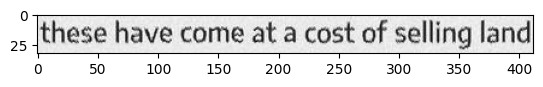

In [ ]:
img = 'text_recognition/sample/97652.jpg'
img = Image.open(img)
plt.imshow(img)
s = model.predict(img)
s

Inference mô hình DBNet đã huấn luyện

In [ ]:
%cd /content/gdrive/MyDrive/Teaching/codes/ocr_27062024/text_detection/src/DB_text_minimal/src

/content/gdrive/MyDrive/Teaching/codes/ocr_27062024/text_detection/src/DB_text_minimal/src


In [ ]:
# Cài thư viên pyclipper cho DBNet
!pip install pyclipper

In [ ]:
from models import DBTextModel
from utils import test_preprocess
from postprocess import SegDetectorRepresenter
import os
import torch
import cv2
import numpy as np
import gc

In [ ]:
def load_detection_model(model_path="../../../weights/best_dbnet.pth", device="cpu"):
    # Check if the model path exists or not
    assert os.path.exists(model_path), "This model path is not exist."

    # Load model DBText
    dbnet = DBTextModel().to(device)
    dbnet.load_state_dict(torch.load(model_path, map_location=device))
    return dbnet

In [ ]:
dbnet = load_detection_model()
dbnet = dbnet.eval()

load from imagenet


In [ ]:
def draw_bbox(img, bboxes, color=(255, 0, 0), thickness=1):
    if isinstance(img, str):
        img = cv2.imread(img)

    img = img.copy()

    for bbox in bboxes:
        bbox = bbox.astype(int)
        cv2.polylines(img, [bbox], True, color, thickness)

    return img

In [ ]:
def preprocess(image_arr, device="cpu"):
    preprocessed_image = test_preprocess(image_arr, to_tensor=True, pad=False).to(device)
    return preprocessed_image

In [ ]:
def get_detected_bbox(image_arr, is_output_polygon=False):
    global dbnet
    # New
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_RGB2GRAY)
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_GRAY2RGB)

    preprocessed_image = preprocess(image_arr)
    print("Image gray:", preprocessed_image)
    h_origin, w_origin, _ = image_arr.shape

    with torch.no_grad():
        preds = dbnet(preprocessed_image)
    print(preds)
    # Change from binary feature map to detection
    seg_obj = SegDetectorRepresenter(thresh=0.1, box_thresh=0.4, unclip_ratio=1.5)
    batch = {'shape': [(h_origin, w_origin)]}
    box_list, _ = seg_obj(batch, preds, is_output_polygon=is_output_polygon)
    box_list = box_list[0]

    print(len(box_list))

    if len(box_list) > 0:
        print("detect")
        if is_output_polygon:
            idx = [x.sum() > 0 for x in box_list]
            # print(idx)
            box_list = [box_list[i] for i, v in enumerate(idx) if v]
        else:
            idx = box_list.reshape(box_list.shape[0], -1).sum(axis=1) > 0
            print(idx)
            box_list= box_list[idx]

        print(len(box_list))
    else:
        box_list = []

    return np.array(box_list)

def detect(image_arr, device="cpu"):
    bboxes = get_detected_bbox(image_arr)
    detected_image = draw_bbox(image_arr, bboxes)

    return bboxes, detected_image

In [ ]:
from PIL import Image

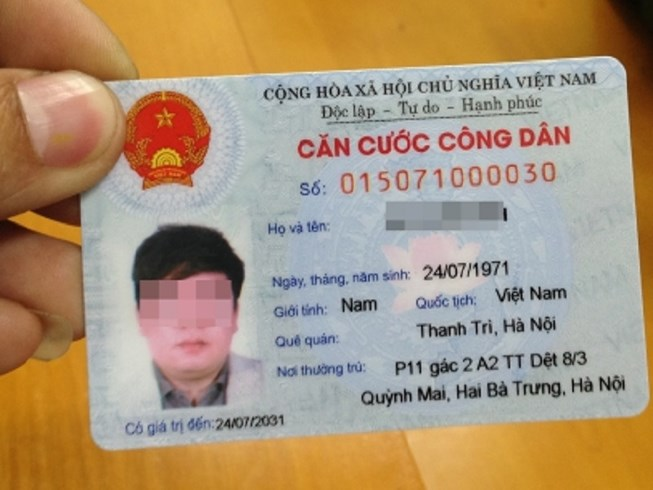

In [ ]:
image = cv2.imread("/content/gdrive/MyDrive/Teaching/codes/ocr_27062024/text_detection/src/demo_results/doi-the-can-cuoc-cong-dan.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
Image.fromarray(image)

In [ ]:
def get_min_max_pos(bbox):
    minx = min(bbox[:, 0])
    maxx = max(bbox[:, 0])
    miny = min(bbox[:, 1])
    maxy = max(bbox[:, 1])

    return minx, miny, maxx, maxy

def get_cropped_area(image_arr, bbox):
    minx, miny, maxx, maxy = get_min_max_pos(bbox)

    return image_arr[miny:maxy, minx:maxx]

In [ ]:
def recog(image_arr, bboxes, device="cuda"):
    global model

    torch.cuda.empty_cache()
    gc.collect()

    cropped_image_batch = [Image.fromarray(get_cropped_area(image_arr, bbox)) for bbox in bboxes]
    pred_texts = model.predict_batch(cropped_image_batch[-1::-1])

    return pred_texts

In [ ]:
def create_result(image_arr, device="cpu"):
    import time
    start = time.time()
    bboxes, detected_image = detect(image_arr, device)
    detect_time = time.time() - start

    start = time.time()
    pred_texts = recog(detected_image, bboxes, device)
    recog_time = time.time() - start

    return detected_image, "\n".join(pred_texts)

In [ ]:
bboxes, _ = detect(image)

Image gray: tensor([[[[ 1.0610e+00,  2.0610e+00,  3.0610e+00,  ..., -8.7939e+01,
           -8.7939e+01, -8.7939e+01],
          [ 6.0997e-02,  6.0997e-02,  1.0610e+00,  ..., -8.7939e+01,
           -8.7939e+01, -8.7939e+01],
          [-9.3900e-01, -1.9390e+00, -9.3900e-01,  ..., -8.7939e+01,
           -8.7939e+01, -8.7939e+01],
          ...,
          [ 1.1061e+01,  1.2061e+01,  1.3061e+01,  ...,  3.2061e+01,
            3.1061e+01,  2.9061e+01],
          [ 1.0061e+01,  1.2061e+01,  1.4061e+01,  ...,  3.1061e+01,
            3.1061e+01,  3.2061e+01],
          [ 1.0061e+01,  1.2061e+01,  1.4061e+01,  ...,  3.0061e+01,
            3.1061e+01,  3.2061e+01]],

         [[-1.1779e+01, -1.0779e+01, -9.7790e+00,  ..., -1.0078e+02,
           -1.0078e+02, -1.0078e+02],
          [-1.2779e+01, -1.2779e+01, -1.1779e+01,  ..., -1.0078e+02,
           -1.0078e+02, -1.0078e+02],
          [-1.3779e+01, -1.4779e+01, -1.3779e+01,  ..., -1.0078e+02,
           -1.0078e+02, -1.0078e+02],
        

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
with gr.Blocks() as demo:
    input_image = gr.Image(label="Test Image")
    detected_output = gr.Image(label="Detected Image")
    recog_output = gr.Textbox(label="Text Result")

    run_button = gr.Button("Run Demo")
#     run_button.click(fn=create_result, inputs=input_image, outputs=[detected_output, recog_output, detect_time_output, recog_time_output, kie_output, kie_time_output])
    run_button.click(fn=create_result, inputs=input_image, outputs=[detected_output, recog_output])

demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://9bcb1b7571502852bd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Image gray: tensor([[[[ 1.0610e+00,  2.0610e+00,  3.0610e+00,  ..., -8.7939e+01,
           -8.7939e+01, -8.7939e+01],
          [ 6.0997e-02,  6.0997e-02,  1.0610e+00,  ..., -8.7939e+01,
           -8.7939e+01, -8.7939e+01],
          [-9.3900e-01, -1.9390e+00, -9.3900e-01,  ..., -8.7939e+01,
           -8.7939e+01, -8.7939e+01],
          ...,
          [ 1.1061e+01,  1.2061e+01,  1.3061e+01,  ...,  3.2061e+01,
            3.1061e+01,  2.9061e+01],
          [ 1.0061e+01,  1.2061e+01,  1.4061e+01,  ...,  3.1061e+01,
            3.1061e+01,  3.2061e+01],
          [ 1.0061e+01,  1.2061e+01,  1.4061e+01,  ...,  3.0061e+01,
            3.1061e+01,  3.2061e+01]],

         [[-1.1779e+01, -1.0779e+01, -9.7790e+00,  ..., -1.0078e+02,
           -1.0078e+02, -1.0078e+02],
          [-1.2779e+01, -1.2779e+01, -1.1779e+01,  ..., -1.0078e+02,
           -1.0078e+02, -1.0078e+02],
          [-1.3779e+01, -1.4779e+01, -1.3779e+01,  ..., -1.0078e+02,
           -1.0078e+02, -1.0078e+02],
        